In [1]:
import matplotlib.pyplot as plt
import pandas, sys
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

Load data in, we will be selecting aggregation propensities measured using the Martini 2.1 forcefield for dipeptides

In [2]:
parameters = pandas.read_csv("Judred.csv", index_col=0)
#print(parameters)
targets = pandas.read_csv("APs.csv", index_col = 0)
#print(targets)

Forcefield = "2.1"
targets = targets[targets["FF"] == Forcefield]
targets.index = targets["pep"]

targets = targets["mean"]
print(targets)

pep
AA    1.023
AC    1.015
AD    1.017
AE    1.012
AF    1.120
      ...  
YS    1.237
YT    1.156
YV    1.115
YW    1.729
YY    1.207
Name: mean, Length: 400, dtype: float64


We split these into training, testing and validation sets

In [3]:
X_train, X_val, y_train, y_val = train_test_split(parameters, targets, test_size=0.33, random_state=9876, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=9876, shuffle=True)

useRBF = False

print("Training data:", X_train.shape)
print("Testing data:", X_test.shape)
print("Validation data:", X_val.shape)

Training data: (179, 10)
Testing data: (89, 10)
Validation data: (132, 10)


We will take a look at how projecting our data into other spaces could improve our predictions. But we will uncomment this at the end to determine its effect.

In [4]:
a="""
X_train, X_val, y_train, y_val = train_test_split(parameters, targets, test_size=0.33, random_state=9876, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=9876, shuffle=True)

# Add kernal trick
def rbf(X, epsilon):
    return np.e ** -(epsilon*X_train)**2

X_train = np.hstack((X_train.values, rbf(X_train, 0.2)))
X_test = np.hstack((X_test.values, np.e ** -(0.2*X_test)**2))
X_val = np.hstack((X_val.values, np.e ** -(0.2*X_val)**2))
print("Training data:", X_train.shape)
print("Testing data:", X_test.shape)
print("Validation data:", X_val.shape)

useRBF = True
#"""

Training data: (179, 20)
Testing data: (89, 20)
Validation data: (132, 20)


Test all the combinations of the hyperparameters on the test set to see what works best for our model

In [5]:
BestHyperparameters = pandas.DataFrame(columns = ["fit_intercept", "positive", "Test data RMSE"])
iteration = 0
for fit_intercept in [True, False]:
    for positive in [True, False]:
        Hyperparameters = {"fit_intercept": fit_intercept,
                           "positive": positive}
        
        model = LinearRegression(**Hyperparameters)

        #Train on the training data
        model.fit(X_train, y_train)
        
        # Test on the Test data
        predictions = model.predict(X_test)
        
        BestHyperparameters.loc[iteration] = [fit_intercept, positive, mean_squared_error(y_test, predictions, squared=False)]
        iteration +=1
BestHyperparameters = BestHyperparameters.sort_values("Test data RMSE", ascending=False)
print(BestHyperparameters)



  fit_intercept positive  Test data RMSE
0          True     True        0.172792
2         False     True        0.172553
3         False    False        0.149009
1          True    False        0.145827


Take our best hyperparameters and make a prediction on the validation set

In [6]:
Hyperparameters = {"fit_intercept": BestHyperparameters.iloc[-1]["fit_intercept"],
                   "positive": BestHyperparameters.iloc[-1]["positive"]}
model = LinearRegression(**Hyperparameters)
model.fit(X_train, y_train)
# Validate on the never before seen in any way validation data
predictions = model.predict(X_val)
RMSE = mean_squared_error(y_val, predictions, squared=False)

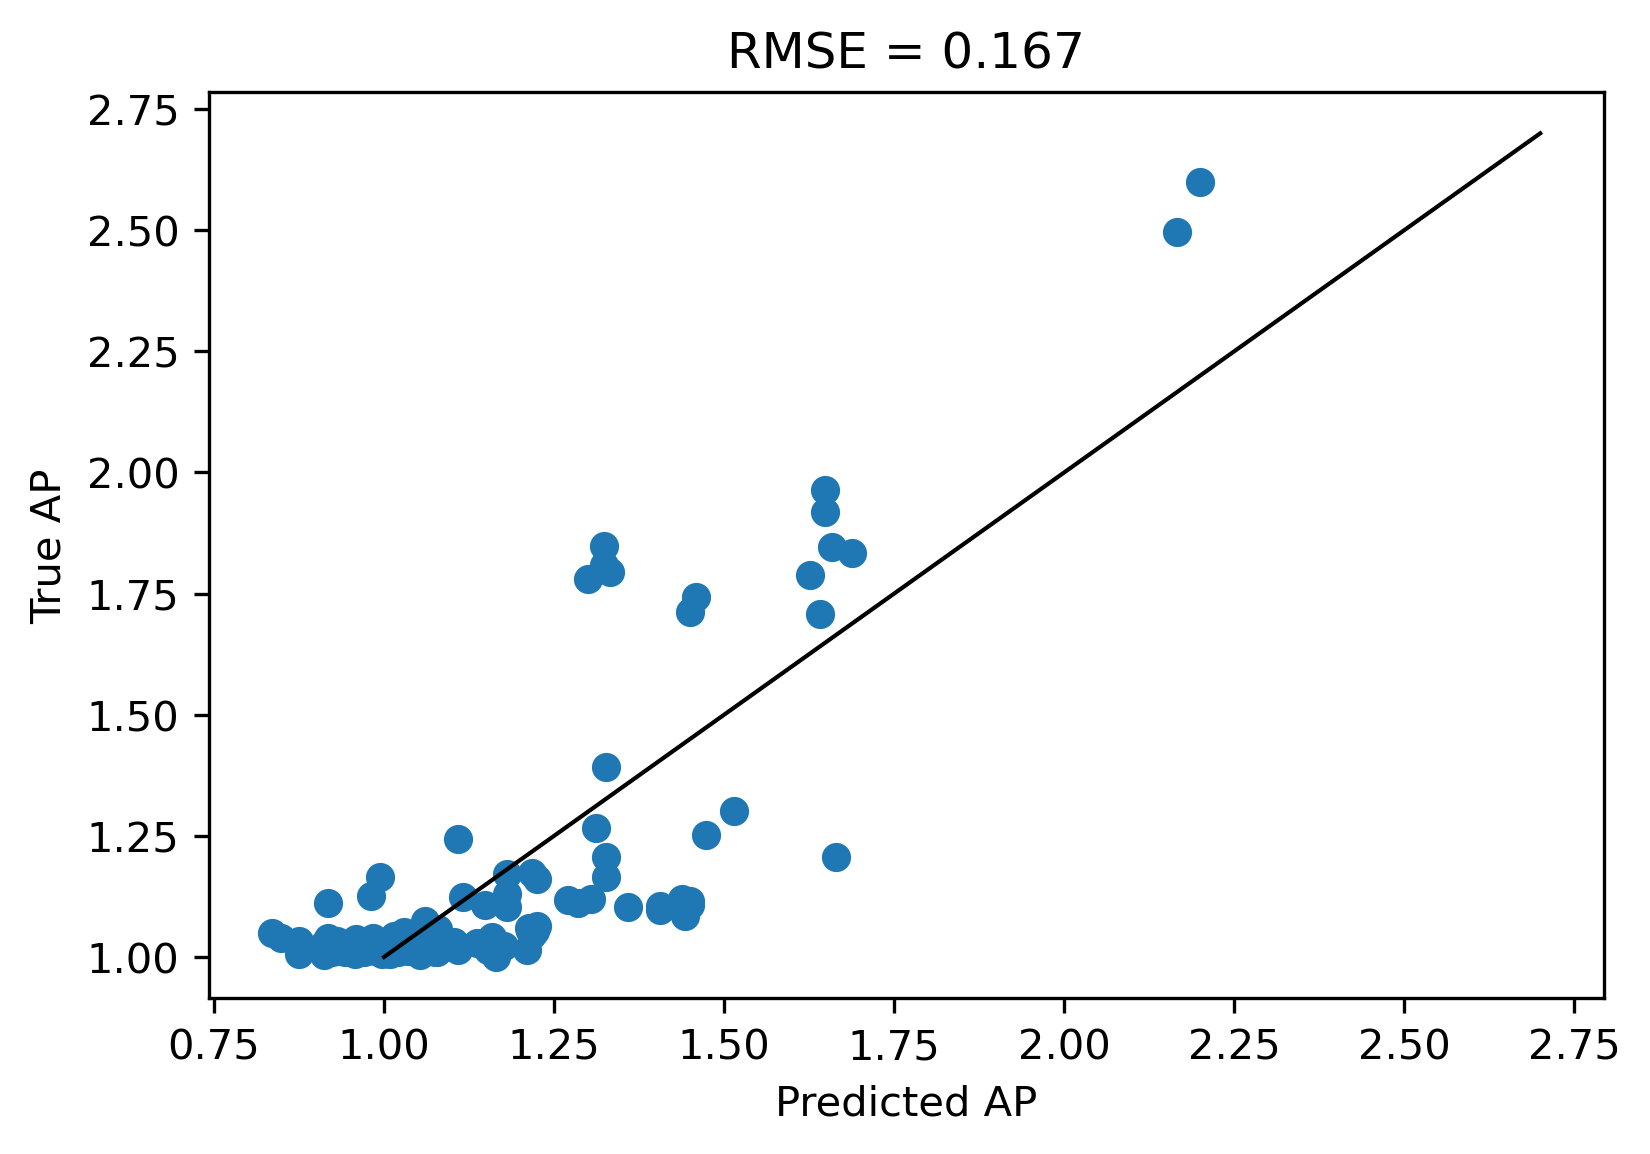

In [8]:
plt.scatter(predictions, y_val)
plt.plot([1,2.7], [1,2.7], lw=1, c="black")
plt.title(f"RMSE = " + "{:1.3f}".format(RMSE))
plt.xlabel("Predicted AP")
plt.ylabel("True AP")
plt.gcf().set_dpi(150)
plt.show()

# Now, go back and add the kernel trick to the data